## Basic KB-NUFFT Example

This notebook implements a basic KB-NUFFT example. It takes a ~~Shepp-Logan phantom~~ brain slice, applies the forward NUFFT, and then the adjoint NUFFT. An alternative processing path is to apply the density compensation function prior to adjoint NUFFT. Both of these examples are included here.

#### Import Stuff

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# from skimage.data import shepp_logan_phantom
from tfkbnufft import kbnufft_forward, kbnufft_adjoint #pip install tfkbnufft
from tfkbnufft.kbnufft import KbNufftModule
from tfkbnufft.mri.dcomp_calc import calculate_radial_dcomp_tf, calculate_density_compensator

dtype = tf.float32

#### Load Data

In [21]:
data = np.load('.\Single-channel-20210319T164234Z-001\Single-channel\Train_part1\Train\e13991s3_P01536.7.npy')
print('Shape is:',data.shape)
print('{} slices, {} x {} image dimensions and, {} real-imaginary'.format(data.shape[0],data.shape[1],data.shape[2],data.shape[3]))

Shape is: (170, 256, 256, 2)
170 slices, 256 x 256 image dimensions and, 2 real-imaginary


Complex number: $z = x+iy$

In [22]:
data2 = data[100,:,:,0] +1j*data[100,:,:,1]

This is k-space data, so in order to see the brain we need to inverse fourier to Image domain.\
We apply $log_{10}$ to k-space data to see nuances better.

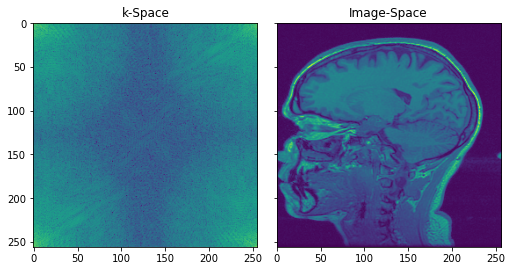

In [23]:
fig, axs = plt.subplots(1, 2,figsize=(7,7),constrained_layout=True, sharey=True)
axs.flat[0].imshow(np.log10(np.abs(data2)))
axs.flat[1].imshow(np.abs(np.fft.ifft2(data2)))
axs[0].set_title('k-Space')
axs[1].set_title('Image-Space')
plt.show()

### Create Spokes

Κάθε ένα spoke που προσθέτουμε στην εικόνα περιστρέφεται κατά:  
$\theta = ga = \frac{180}{\phi} =\frac{180}{\frac{1}{2}(1+\sqrt{5})} \approx 111.246^{o}$  
ώστε να γεμίσει πλήρως ο χώρος από spokes.  
$kx \rightarrow (256,256)$   
$ky \rightarrow (256,256)$   
$\begin{bmatrix}kx \\ ky\end{bmatrix} \rightarrow \begin{bmatrix}kx \\ ky\end{bmatrix} \begin{bmatrix}cos(\theta) & sin(\theta) \\-sin(\theta) & cos(\theta) \end{bmatrix}$

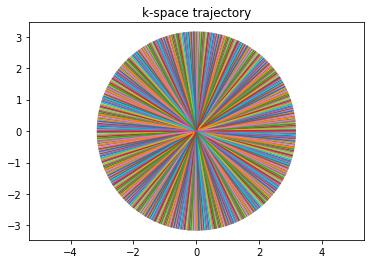

In [24]:
# create a k-space trajectory and plot it
data3 = np.fft.ifft2(data2) #256x256
spokelength = data3.shape[0]*2 #256
grid_size = (spokelength, spokelength)#256x256
nspokes = 256

ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2)) 
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
kx[:, 0] = np.linspace(-np.pi, np.pi, spokelength)
for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
    ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
    
ky = np.transpose(ky)
kx = np.transpose(kx)

ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

# plot the first 40 spokes
plt.plot(kx[:, :].transpose(), ky[:, :].transpose())
plt.axis('equal')
plt.title('k-space trajectory')
plt.show()

#### create NUFFT objects, use 'ortho' for orthogonal FFTs

In [25]:
nufft_ob = KbNufftModule(im_size=(data3.shape[0],data3.shape[0]), grid_size=grid_size, norm='ortho')
print(nufft_ob)


KbNufftModule
----------------------------------------
   im_size: (256, 256)
   im_rank: 2
   grad_traj: False
   grid_size: (512, 512)
   n_shift: (128, 128)
   numpoints: (6, 6)
   alpha: (14.04, 14.04)
   order: (0, 0)
   table: 2 arrays, lengths: (1024, 1024)
   scaling_coef: (256, 256) float64 array
   norm: ortho
   coil_broadcast: False
   matadj: False
   scaling_coef_tensor: (256, 256) <dtype: 'float64'> array
   n_shift_tensor: [128 128]
   grid_size_tensor: [512 512]
   im_size_tensor: [256 256]
   numpoints_tensor: [6. 6.]



Fix Dimensions:

In [26]:
# convert k-space trajectory to a tensor and unsqueeze batch dimension
print('ktraj shape: {}'.format(ktraj.shape))
ktraj = tf.convert_to_tensor(ktraj)[None, ...]
# convert k-space trajectory to a tensor and unsqueeze batch dimension
data3 = tf.convert_to_tensor(data3)[None,None, ...]
print('data3 shape: {}'.format(data3.shape))

ktraj shape: (2, 131072)
data3 shape: (1, 1, 256, 256)


### With Noise
#### Apply Undersampling
`ktraj` has the spokes' information while `data3` has the image domain information,  
we apply kbnufft forward fourier transform.  
We also add some random noise.  
`kbnufft_forward` applies FFT and interpolates from gridded data to scattered data

In [27]:
kdata = kbnufft_forward(nufft_ob._extract_nufft_interpob())(data3, ktraj)
# add some noise (robustness test)
siglevel = tf.reduce_mean(tf.math.abs(data3))
kdatanoise = kdata + tf.cast((siglevel/5) *tf.random.normal(kdata.shape, dtype=siglevel.dtype), kdata.dtype)

#### Interpolate WITHOUT density compensation
`kbnufft_adjoint` Interpolates from scattered data to gridded data and then iFFT,  
since kdata is k-space data.

In [28]:
interpob = nufft_ob._extract_nufft_interpob() #interpolation object
nufft_adj = kbnufft_adjoint(interpob)
image_blurry = nufft_adj(kdatanoise, ktraj)

#### Interpolate WITH density compensation (2 ways)

In [29]:
dcomp = calculate_radial_dcomp_tf(interpob, kbnufft_forward(interpob), nufft_adj, ktraj[0])[None, :]
dcomp_new = calculate_density_compensator(interpob, kbnufft_forward(interpob), nufft_adj, ktraj[0])[None, :]
image_sharp = nufft_adj(kdatanoise * tf.cast(dcomp, kdatanoise.dtype), ktraj)
image_sharp_new = nufft_adj(kdatanoise * tf.cast(dcomp_new, kdatanoise.dtype), ktraj)

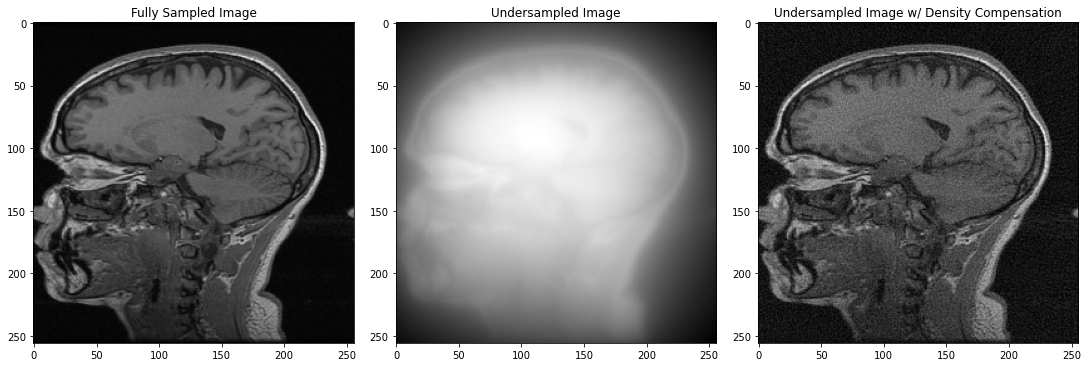

In [41]:
# plot the kernel
fig, axs = plt.subplots(1, 3,figsize=(15,15),constrained_layout=True)
axs.flat[0].imshow(np.abs(np.fft.ifft2(data2)),cmap='gray')
axs.flat[1].imshow(np.squeeze(np.abs(image_blurry)),cmap='gray')
axs.flat[2].imshow(np.squeeze(np.abs(image_sharp_new)),cmap='gray')
axs.flat[0].set_title('Fully Sampled Image')
axs.flat[1].set_title('Undersampled Image')
axs.flat[2].set_title('Undersampled Image w/ Density Compensation')
plt.show()

### Without Noise

In [31]:
kdata = kbnufft_forward(nufft_ob._extract_nufft_interpob())(data3, ktraj)
image_blu = nufft_adj(kdata, ktraj)
dcomp_new = calculate_density_compensator(interpob, kbnufft_forward(interpob), nufft_adj, ktraj[0])[None, :]
image_DC = nufft_adj(kdata * tf.cast(dcomp_new, kdata.dtype), ktraj)

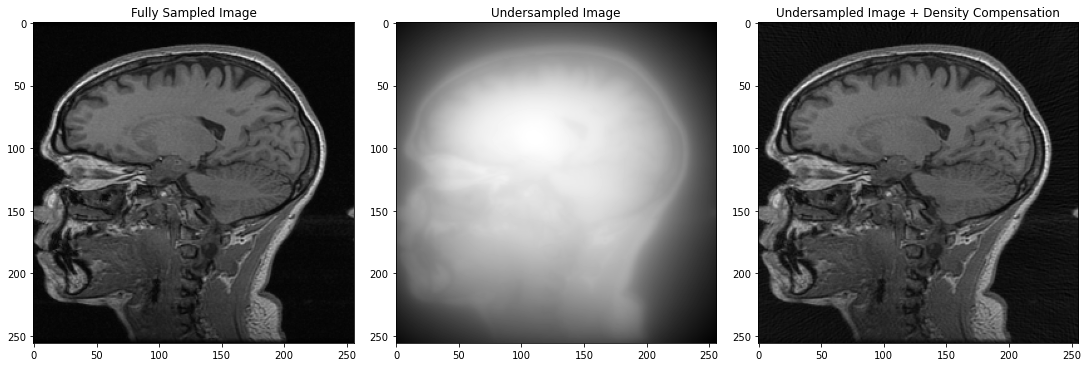

In [42]:
# plot the kernel
fig, axs = plt.subplots(1, 3,figsize=(15,15),constrained_layout=True)
axs.flat[0].imshow(np.abs(np.fft.ifft2(data2)),cmap='gray')
axs.flat[1].imshow(np.squeeze(np.abs(image_blu)),cmap='gray')
axs.flat[2].imshow(np.squeeze(np.abs(image_DC)),cmap='gray')
axs.flat[0].set_title('Fully Sampled Image')
axs.flat[1].set_title('Undersampled Image')
axs.flat[2].set_title('Undersampled Image + Density Compensation')
plt.show()